In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 加载数据
data1 = pd.read_pickle("data1_cleaned.pkl")
data2 = pd.read_pickle("data2_cleaned.pkl")

# 显示数据基本信息
print("data1的基本信息：")
print(f"形状: {data1.shape}")
print(f"时间范围: {data1.index.get_level_values('date').min().date()} 到 {data1.index.get_level_values('date').max().date()}")
print(f"股票数量: {len(data1.index.get_level_values('stock').unique())}")
print(f"列数: {len(data1.columns)}")
print("\n前5个因子名称：")
print(data1.columns[1:6].tolist())  # 跳过returns列

print("\ndata2的基本信息：")
print(f"形状: {data2.shape}")
print(f"时间范围: {data2.index.get_level_values('date').min().date()} 到 {data2.index.get_level_values('date').max().date()}")
print(f"股票数量: {len(data2.index.get_level_values('stock').unique())}")
print(f"列数: {len(data2.columns)}")
print("\n前5个因子名称：")
print(data2.columns[1:6].tolist())  # 跳过returns列

data1的基本信息：
形状: (786652, 203)
时间范围: 1998-01-31 到 2024-08-31
股票数量: 5371
列数: 203

前5个因子名称：
['total_skewness_252', 'net_profit_growth_to_asset', 'information_discreteness', 'ebit_yoy_pct_chg', 'accrual_to_asset_ttm']

data2的基本信息：
形状: (786652, 203)
时间范围: 1998-01-31 到 2024-08-31
股票数量: 5371
列数: 203

前5个因子名称：
['total_skewness_252', 'net_profit_growth_to_asset', 'information_discreteness', 'ebit_yoy_pct_chg', 'accrual_to_asset_ttm']


现在我们开始对每个单因子做ic筛选。首先对第一个进行试着筛选：

Factor total_skewness_252 IC Statistics:
Mean IC: -0.0323
IC Std: 0.1139
ICIR: -0.2834
Positive IC Ratio: 37.93%
IC Series Length: 319


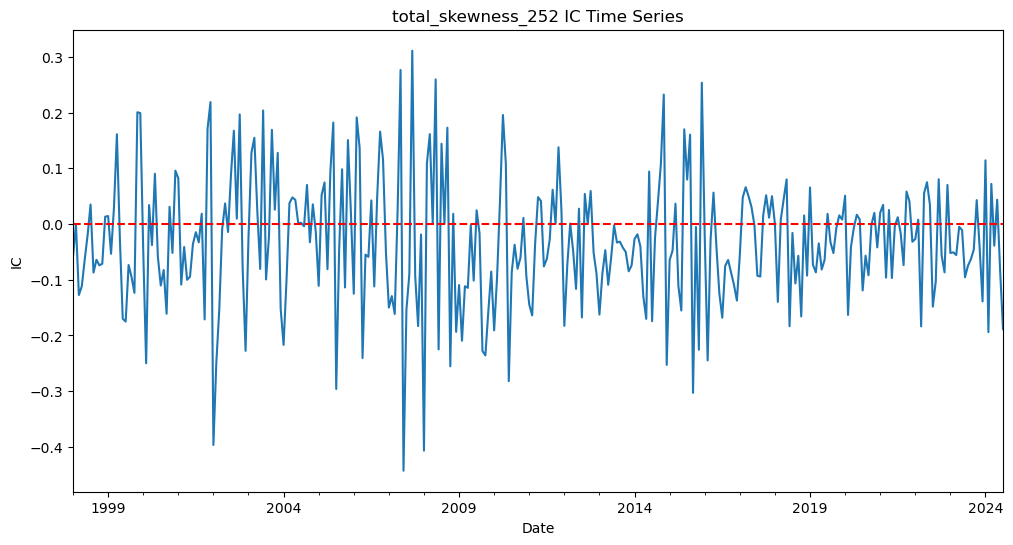

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# 获取第一个因子
factor_name = 'total_skewness_252'

# 初始化存储IC的列表
ic_series = []
ic_dates = []

# 获取所有月份
dates = sorted(data1.index.get_level_values('date').unique())

# 循环计算每个月的IC
for i in range(len(dates)-1):  # 不计算最后一个月的IC
    current_date = dates[i]
    next_date = dates[i+1]
    
    # 获取当前月的因子值和下月的收益率
    current_factor = data1.xs(current_date, level='date')[factor_name]
    next_returns = data1.xs(next_date, level='date')['return']
    
    # 找出同时有因子值和收益率的股票
    common_stocks = current_factor.index.intersection(next_returns.index)
    
    if len(common_stocks) > 0:  # 确保有足够的样本
        # 计算秩相关系数
        ic = spearmanr(current_factor[common_stocks], next_returns[common_stocks])[0]
        ic_series.append(ic)
        ic_dates.append(current_date)

# 转换为Series
ic_series = pd.Series(ic_series, index=ic_dates)

# 计算统计指标
mean_ic = ic_series.mean()
std_ic = ic_series.std()
ic_ir = mean_ic / std_ic
positive_ic_ratio = (ic_series > 0).mean()

# 打印结果
print(f"Factor {factor_name} IC Statistics:")
print(f"Mean IC: {mean_ic:.4f}")
print(f"IC Std: {std_ic:.4f}")
print(f"ICIR: {ic_ir:.4f}")
print(f"Positive IC Ratio: {positive_ic_ratio:.2%}")
print(f"IC Series Length: {len(ic_series)}")

# 可视化IC时间序列
plt.figure(figsize=(12, 6))
ic_series.plot()
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'{factor_name} IC Time Series')
plt.xlabel('Date')
plt.ylabel('IC')
plt.show()

上面的因子展示了一些他的特征，现在我们开始对每个因子进行ic筛选。

我们筛选的标准是：

Mean IC > 0.03

ICIR > 0.5

Positive IC Ratio > 65%


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# 初始化存储结果的字典
selected_factors = []

# 获取所有因子（跳过returns列）
factors = data1.columns[1:]

# 循环计算每个因子的IC统计
for factor_name in factors:
    # 初始化存储IC的列表
    ic_series = []
    ic_dates = []
    
    # 获取所有月份
    dates = sorted(data1.index.get_level_values('date').unique())
    
    # 循环计算每个月的IC
    for i in range(len(dates)-1):
        current_date = dates[i]
        next_date = dates[i+1]
        
        # 获取当前月的因子值和下月的收益率
        current_factor = data1.xs(current_date, level='date')[factor_name]
        next_returns = data1.xs(next_date, level='date')['return']
        
        # 找出同时有因子值和收益率的股票
        common_stocks = current_factor.index.intersection(next_returns.index)
        
        if len(common_stocks) > 0:
            # 检查是否有足够的变异性
            factor_values = current_factor[common_stocks]
            return_values = next_returns[common_stocks]
            
            if (factor_values.nunique() > 1) and (return_values.nunique() > 1):
                # 计算秩相关系数
                ic = spearmanr(factor_values, return_values)[0]
                ic_series.append(ic)
                ic_dates.append(current_date)
    
    # 转换为Series
    ic_series = pd.Series(ic_series, index=ic_dates)
    
    # 计算统计指标
    mean_ic = ic_series.mean()
    std_ic = ic_series.std()
    ic_ir = mean_ic / std_ic
    positive_ic_ratio = (ic_series > 0).mean()
    
    # 检查是否满足筛选条件

if (mean_ic > 0.03) and (ic_ir > 0.5) and (positive_ic_ratio > 0.65):
    selected_factors.append(factor_name)

# 打印结果
print(f"总因子数量: {len(factors)}")
print(f"筛选后的因子数量: {len(selected_factors)}")
print("\n筛选出的因子:")
for factor in selected_factors:
    print(factor)

总因子数量: 202
筛选后的因子数量: 0

筛选出的因子:


In [4]:
# 初始化存储次优因子的字典
suboptimal_factors = []

# 获取所有因子（跳过returns列）
factors = data1.columns[1:]

# 循环计算每个因子的IC统计
for factor_name in factors:
    # 初始化存储IC的列表
    ic_series = []
    ic_dates = []
    
    # 获取所有月份
    dates = sorted(data1.index.get_level_values('date').unique())
    
    # 循环计算每个月的IC
    for i in range(len(dates)-1):
        current_date = dates[i]
        next_date = dates[i+1]
        
        # 获取当前月的因子值和下月的收益率
        current_factor = data1.xs(current_date, level='date')[factor_name]
        next_returns = data1.xs(next_date, level='date')['return']
        
        # 找出同时有因子值和收益率的股票
        common_stocks = current_factor.index.intersection(next_returns.index)
        
        if len(common_stocks) > 0:
            # 检查是否有足够的变异性
            factor_values = current_factor[common_stocks]
            return_values = next_returns[common_stocks]
            
            if (factor_values.nunique() > 1) and (return_values.nunique() > 1):
                # 计算秩相关系数
                ic = spearmanr(factor_values, return_values)[0]
                ic_series.append(ic)
                ic_dates.append(current_date)
    
    # 转换为Series
    ic_series = pd.Series(ic_series, index=ic_dates)
    
    # 计算统计指标
    mean_ic = ic_series.mean()
    std_ic = ic_series.std()
    ic_ir = mean_ic / std_ic
    positive_ic_ratio = (ic_series > 0).mean()
    
    # 检查是否满足次优条件
    if (mean_ic > 0.015) and (ic_ir > 0.3) and (positive_ic_ratio > 0.55):
        suboptimal_factors.append(factor_name)

# 打印结果
print(f"总因子数量: {len(factors)}")
print(f"次优因子数量: {len(suboptimal_factors)}")
print("\n次优因子:")
for factor in suboptimal_factors:
    print(factor)

总因子数量: 202
次优因子数量: 22

次优因子:
std_unexpected_net_profit_with_drift
std_unexpected_revenue_with_drift
liquidity_shock_21_252
adminexp_to_total_mktcap_ttm
idios_momentum_ff3_252_21
std_unexpected_net_profit_using_ar
idios_momentum_capm_252_21
asset_turnover_yoy_chg
sellexp_to_total_mktcap_ttm
net_profit_to_asset_yoy_chg_acc
net_profit_yoy_pct_chg_acc
fscore
book_value_to_total_mktcap_mrq
buffett_zscore
tpi_21
revenue_to_net_operating_asset_yoy_chg
revenue_to_total_mktcap_ttm
book_value_plus_rdexp_to_total_mktcap_ttm
net_cash_flow_to_total_mktcap_ttm
gross_profit_to_asset_yoy_chg
std_unexpected_net_profit
book_value_plus_rdexp_sga_to_total_mktcap_ttm


In [5]:
# 打印优质因子和次优因子的对比
print("=== 因子筛选结果对比 ===")
print(f"\n优质因子数量: {len(selected_factors)}")
print("优质因子列表:")
for factor in selected_factors:
    print(f"- {factor}")

print(f"\n次优因子数量: {len(suboptimal_factors)}")
print("次优因子列表:")
for factor in suboptimal_factors:
    print(f"- {factor}")

# 计算两个集合的差异
only_in_optimal = set(selected_factors) - set(suboptimal_factors)
only_in_suboptimal = set(suboptimal_factors) - set(selected_factors)
common_factors = set(selected_factors) & set(suboptimal_factors)

print("\n=== 因子集合分析 ===")
print(f"仅在优质因子中的数量: {len(only_in_optimal)}")
print(f"仅在次优因子中的数量: {len(only_in_suboptimal)}")
print(f"同时在两个集合中的数量: {len(common_factors)}")

if only_in_optimal:
    print("\n仅在优质因子中的因子:")
    for factor in only_in_optimal:
        print(f"- {factor}")

if only_in_suboptimal:
    print("\n仅在次优因子中的因子:")
    for factor in only_in_suboptimal:
        print(f"- {factor}")

if common_factors:
    print("\n同时在两个集合中的因子:")
    for factor in common_factors:
        print(f"- {factor}")

=== 因子筛选结果对比 ===

优质因子数量: 0
优质因子列表:

次优因子数量: 22
次优因子列表:
- std_unexpected_net_profit_with_drift
- std_unexpected_revenue_with_drift
- liquidity_shock_21_252
- adminexp_to_total_mktcap_ttm
- idios_momentum_ff3_252_21
- std_unexpected_net_profit_using_ar
- idios_momentum_capm_252_21
- asset_turnover_yoy_chg
- sellexp_to_total_mktcap_ttm
- net_profit_to_asset_yoy_chg_acc
- net_profit_yoy_pct_chg_acc
- fscore
- book_value_to_total_mktcap_mrq
- buffett_zscore
- tpi_21
- revenue_to_net_operating_asset_yoy_chg
- revenue_to_total_mktcap_ttm
- book_value_plus_rdexp_to_total_mktcap_ttm
- net_cash_flow_to_total_mktcap_ttm
- gross_profit_to_asset_yoy_chg
- std_unexpected_net_profit
- book_value_plus_rdexp_sga_to_total_mktcap_ttm

=== 因子集合分析 ===
仅在优质因子中的数量: 0
仅在次优因子中的数量: 22
同时在两个集合中的数量: 0

仅在次优因子中的因子:
- std_unexpected_net_profit_with_drift
- std_unexpected_net_profit
- std_unexpected_revenue_with_drift
- adminexp_to_total_mktcap_ttm
- revenue_to_net_operating_asset_yoy_chg
- revenue_to_total_mktcap_

In [6]:
# 创建data1_good.pkl（使用优质因子）
data1_good = data1[['return'] + selected_factors].copy()
data1_good.to_pickle('data1_good.pkl')

# 创建data1_normal.pkl（使用次优因子）
data1_normal = data1[['return'] + suboptimal_factors].copy()
data1_normal.to_pickle('data1_normal.pkl')

# 打印信息确认
print("data1_good.pkl 信息：")
print(f"列数: {len(data1_good.columns)}")
print(f"列名: {data1_good.columns.tolist()}")

print("\ndata1_normal.pkl 信息：")
print(f"列数: {len(data1_normal.columns)}")
print(f"列名: {data1_normal.columns.tolist()}")

data1_good.pkl 信息：
列数: 1
列名: ['return']

data1_normal.pkl 信息：
列数: 23
列名: ['return', 'std_unexpected_net_profit_with_drift', 'std_unexpected_revenue_with_drift', 'liquidity_shock_21_252', 'adminexp_to_total_mktcap_ttm', 'idios_momentum_ff3_252_21', 'std_unexpected_net_profit_using_ar', 'idios_momentum_capm_252_21', 'asset_turnover_yoy_chg', 'sellexp_to_total_mktcap_ttm', 'net_profit_to_asset_yoy_chg_acc', 'net_profit_yoy_pct_chg_acc', 'fscore', 'book_value_to_total_mktcap_mrq', 'buffett_zscore', 'tpi_21', 'revenue_to_net_operating_asset_yoy_chg', 'revenue_to_total_mktcap_ttm', 'book_value_plus_rdexp_to_total_mktcap_ttm', 'net_cash_flow_to_total_mktcap_ttm', 'gross_profit_to_asset_yoy_chg', 'std_unexpected_net_profit', 'book_value_plus_rdexp_sga_to_total_mktcap_ttm']


做一些可视化：

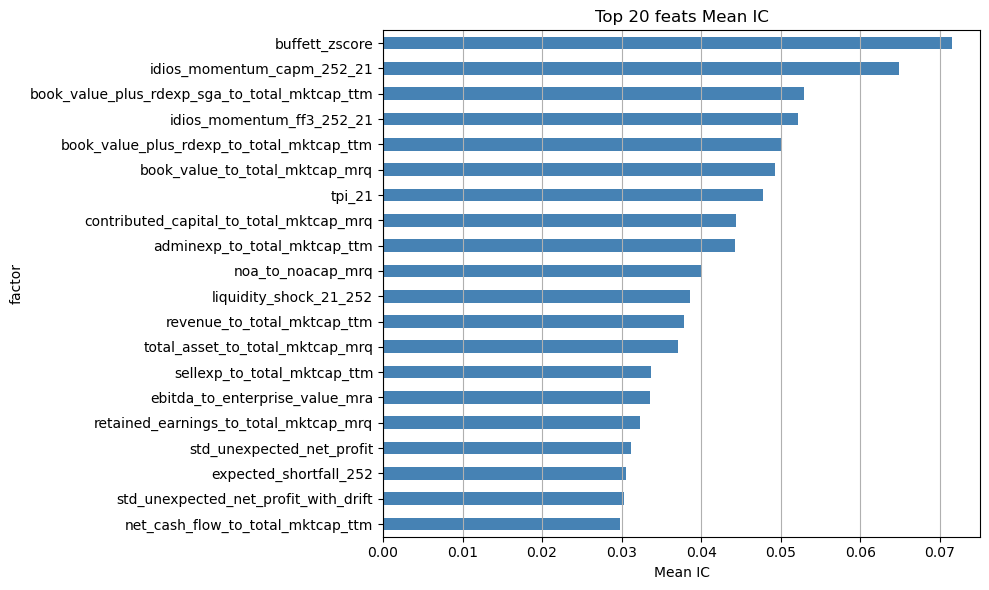

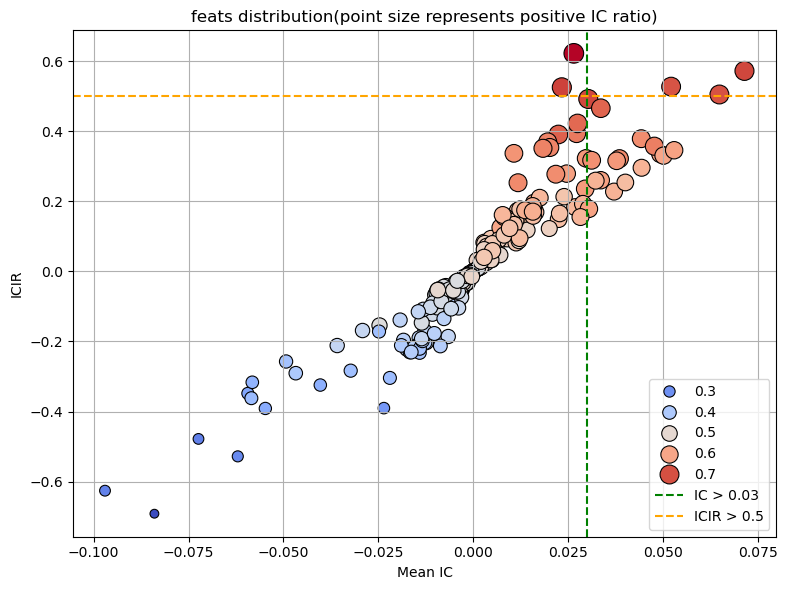


优质因子数量：3
优质因子名称：
['idios_momentum_ff3_252_21', 'idios_momentum_capm_252_21', 'buffett_zscore']

次优因子数量：22
次优因子名称：
['std_unexpected_net_profit_with_drift', 'std_unexpected_revenue_with_drift', 'liquidity_shock_21_252', 'adminexp_to_total_mktcap_ttm', 'idios_momentum_ff3_252_21', 'std_unexpected_net_profit_using_ar', 'idios_momentum_capm_252_21', 'asset_turnover_yoy_chg', 'sellexp_to_total_mktcap_ttm', 'net_profit_to_asset_yoy_chg_acc', 'net_profit_yoy_pct_chg_acc', 'fscore', 'book_value_to_total_mktcap_mrq', 'buffett_zscore', 'tpi_21', 'revenue_to_net_operating_asset_yoy_chg', 'revenue_to_total_mktcap_ttm', 'book_value_plus_rdexp_to_total_mktcap_ttm', 'net_cash_flow_to_total_mktcap_ttm', 'gross_profit_to_asset_yoy_chg', 'std_unexpected_net_profit', 'book_value_plus_rdexp_sga_to_total_mktcap_ttm']


In [7]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# === 读取数据 ===
data1 = pd.read_pickle("data1_cleaned.pkl")
factors = data1.columns[1:]

# === 初始化容器 ===
selected_factors = []
suboptimal_factors = []
mean_ics, std_ics, ic_irs, positive_ic_ratios = [], [], [], []

# === IC计算 + 筛选 ===
for factor_name in factors:
    ic_series = []
    ic_dates = []
    dates = sorted(data1.index.get_level_values('date').unique())

    for i in range(len(dates)-1):
        current_date = dates[i]
        next_date = dates[i+1]

        current_factor = data1.xs(current_date, level='date')[factor_name]
        next_returns = data1.xs(next_date, level='date')['return']
        common_stocks = current_factor.index.intersection(next_returns.index)

        if len(common_stocks) > 0:
            factor_values = current_factor[common_stocks]
            return_values = next_returns[common_stocks]

            if (factor_values.nunique() > 1) and (return_values.nunique() > 1):
                ic = spearmanr(factor_values, return_values)[0]
                ic_series.append(ic)
                ic_dates.append(current_date)

    ic_series = pd.Series(ic_series, index=ic_dates)
    mean_ic = ic_series.mean()
    std_ic = ic_series.std()
    ic_ir = mean_ic / std_ic if std_ic != 0 else np.nan
    positive_ic_ratio = (ic_series > 0).mean()

    # 保存统计指标
    mean_ics.append(mean_ic)
    std_ics.append(std_ic)
    ic_irs.append(ic_ir)
    positive_ic_ratios.append(positive_ic_ratio)

    # 判断优质因子
    if (mean_ic > 0.03) and (ic_ir > 0.5) and (positive_ic_ratio > 0.65):
        selected_factors.append(factor_name)

    # 判断次优因子
    if (mean_ic > 0.015) and (ic_ir > 0.3) and (positive_ic_ratio > 0.55):
        suboptimal_factors.append(factor_name)

# === 构建 DataFrame ===
factor_stats = pd.DataFrame({
    "factor": factors,
    "mean_ic": mean_ics,
    "std_ic": std_ics,
    "icir": ic_irs,
    "positive_ic_ratio": positive_ic_ratios
}).set_index("factor")

# === 图一：Top 20 Mean IC 因子 ===
top20 = factor_stats.sort_values("mean_ic", ascending=False).head(20)
plt.figure(figsize=(10, 6))
top20["mean_ic"].plot(kind="barh", color="steelblue")
plt.xlabel("Mean IC")
plt.title("Top 20 feats Mean IC")
plt.gca().invert_yaxis()
plt.grid(axis="x")
plt.tight_layout()
plt.show()

# === 图二：IC vs ICIR 散点图 ===
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=factor_stats,
    x="mean_ic", y="icir",
    hue="positive_ic_ratio", size="positive_ic_ratio",
    palette="coolwarm", sizes=(40, 200), edgecolor="black"
)
plt.axvline(0.03, linestyle='--', color='green', label="IC > 0.03")
plt.axhline(0.5, linestyle='--', color='orange', label="ICIR > 0.5")
plt.xlabel("Mean IC")
plt.ylabel("ICIR")
plt.title("feats distribution(point size represents positive IC ratio)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 输出结果 ===
print(f"\n优质因子数量：{len(selected_factors)}")
print("优质因子名称：")
print(selected_factors)

print(f"\n次优因子数量：{len(suboptimal_factors)}")
print("次优因子名称：")
print(suboptimal_factors)
